In [1]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Activation, BatchNormalization, Dropout, Reshape
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sn
import collections
import pandas as pd 
import os

2.8.0
Num GPUs Available:  1


# 加载原始数据

In [2]:
file = r'./Data_set/win_9_overlap_4.5.mat'
data = loadmat(file, mat_dtype=True)
motion_py1 = data['out_feature']
x = motion_py1[:,0:180]
y = motion_py1[:,180]
y = y.astype(int)


num_classes = 2
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(x, y, test_size = 0.30, random_state = 50)
X_test, X_val, label_test, label_val = train_test_split(X_test_a, y_test_a, test_size = 0.50, random_state = 50)
X_train, label_train = ADASYN().fit_resample(X_train_a, y_train_a)
# X_train, label_train = X_train_a, y_train_a

y_train = tf.keras.utils.to_categorical(label_train,num_classes)
y_test = tf.keras.utils.to_categorical(label_test,num_classes)
y_val = tf.keras.utils.to_categorical(label_val,num_classes)
X_train.shape, X_test.shape, X_val.shape

((51198, 180), (5947, 180), (5948, 180))

In [3]:
Time_period = 180
num_channels = 1
input_shape = (Time_period, num_channels)
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, activation = tf.nn.tanh), input_shape=input_shape))
model.add(Bidirectional(LSTM(64, activation = tf.nn.tanh)))
# model.add(Dense(64, activation=tf.nn.tanh))
# model.add(BatchNormalization())
model.add(Dense(num_classes, activation=tf.nn.softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 180, 128)         33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 132,866
Trainable params: 132,866
Non-trainable params: 0
_________________________________________________________________


In [4]:
initial_learning_rate = 1e-3

batch_size = 128

Epoch = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model.compile(
            loss = tf.keras.losses.BinaryFocalCrossentropy(),
#             loss = 'categorical_crossentropy',
            optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
            metrics=['accuracy'])

In [5]:
history = model.fit(  
    X_train,
    y_train,
    batch_size = batch_size,
    # 这个是指模型只迭代一次
    epochs = Epoch,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 39s 82ms/step - loss: 0.1733 - accuracy: 0.5314 - val_loss: 0.1770 - val_accuracy: 0.2656
Epoch 2/100
400/400 [==============================] - 31s 78ms/step - loss: 0.1716 - accuracy: 0.5328 - val_loss: 0.1760 - val_accuracy: 0.6587
Epoch 3/100
400/400 [==============================] - 30s 76ms/step - loss: 0.1715 - accuracy: 0.5263 - val_loss: 0.1627 - val_accuracy: 0.8302
Epoch 4/100
400/400 [==============================] - 30s 76ms/step - loss: 0.1711 - accuracy: 0.5310 - val_loss: 0.1553 - val_accuracy: 0.9092
Epoch 5/100
400/400 [==============================] - 31s 78ms/step - loss: 0.1713 - accuracy: 0.5260 - val_loss: 0.1472 - val_accuracy: 0.9122
Epoch 6/100
400/400 [==============================] - 30s 75ms/step - loss: 0.1710 - accuracy: 0.5325 - val_loss: 0.1699 - val_accuracy: 0.8462
Epoch 7/100
400/400 [==============================] - 30s 75ms/step - loss: 0.1709 - accuracy: 0.5307 - val_loss: 0.1647 - val_ac

In [6]:
y_pre = np.argmax(model.predict(X_test), axis=-1)
y_pre = y_pre.astype(int)
accuracy = metrics.accuracy_score(label_test, y_pre)  # 计算准确度
kappa = metrics.cohen_kappa_score(label_test, y_pre)  # 计算kappa
f1_score = metrics.f1_score(label_test, y_pre, average='macro')

In [7]:
print("Test accuracy: {:.6f}".format(accuracy))
print("Kappa: {:.6f}".format(kappa))
print("F1-score: {:.6f}".format(f1_score))

Test accuracy: 0.901967
Kappa: 0.064037
F1-score: 0.530376


[[5327  211]
 [ 372   37]]
Accuracy: 0.9019673785101732
Sensitivity: 0.09046454767726161
Specificity: 0.9618996027446731
Kappa: 0.064037
F1-score: 0.530376


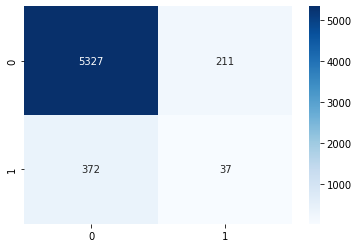

In [8]:
# Making the Confusion Matrix
cm = confusion_matrix(label_test, y_pre)
print(cm)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
print('Accuracy:',(TP+TN) / float(TP+TN+FP+FN))
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))
kappa = metrics.cohen_kappa_score(label_test, y_pre)  # 计算kappa
f1_score = metrics.f1_score(label_test, y_pre, average='macro')
print("Kappa: {:.6f}".format(kappa))
print("F1-score: {:.6f}".format(f1_score))

df=pd.DataFrame(cm)
sn.heatmap(df,fmt='g',annot=True,cmap='Blues')
plt.show()